In [1]:
from cuda import cuda
import argparse
import os
import shutil
from loguru import logger

import tensorrt as trt
import torch
import torch.nn as nn
from yolox.utils import fuse_model

from yolox.exp import get_exp
import cv2
import torchvision
import numpy as np

from matplotlib import pyplot as plt
from yolox.exp import Exp
import utility

from io import BytesIO

import onnx

from onnx import TensorProto
try:
    import onnxsim
except ImportError:
    onnxsim = None



In [2]:
import torch_tensorrt

In [3]:
#--------------Base Param------------
w_h = [1280, 480]
BATCH_SIZE = 1
num_workers =1
file_root = '/home/user/Dataset/'
#--------------Base Param------------
#--------------Class Param------------
all_classes =  ['Ped', 'Cyc', 'Mobike', 'Car', 'Bus', 'Cone', 'TL','VehLane', 'OutgoLane', 'MiddleLane', 'IncomLane',  'Pav', 'Jun', 'Xing_L', 'BusStop', 'Parking_L','Red', 'Amber', 'Green', 'MovAway', 'MovTow', 'Blocking', 'Informing', 'Brake', 'Stop', 'IncatLft',
                   'IncatRht', 'HazLit', 'HeadingLft', 'HeadingRht', 'Parking', 'EmVeh', 'School', 'Control', 'Xing']
len_class = len(all_classes)
agent_classes =  ['Ped', 'Cyc', 'Mobike', 'Car', 'Bus', 'Cone', 'TL']
loc_classes =  ['VehLane', 'OutgoLane', 'MiddleLane', 'IncomLane',  'Pav', 'Jun', 'Xing_L', 'BusStop', 'Parking_L']
action_classes =  ['Red', 'Amber', 'Green', 'MovAway', 'MovTow', 'Blocking', 'Informing', 'Brake', 'Stop', 'IncatLft',
                   'IncatRht', 'HazLit', 'HeadingLft', 'HeadingRht', 'Parking', 'EmVeh', 'School', 'Control', 'Xing']
class_nums = [len(agent_classes), len(loc_classes), len(action_classes)]
#--------------Class Param------------

#--------------Learning Rate Param------------
T_0=20 # Initial Cycle Length
T_mult=2 # Cycle Length multiplier
eta_max=1e-4 # Max LR
T_up=10  # WarmUp Length
gamma=0.5 # LR reducer

start_epoch =0
num_epochs = 120
best_acc = -1

#--------------Learning Rate Param------------

In [4]:
#Model Create

exp = Exp(class_nums = class_nums)
model = exp.get_model()
#model = load_my_state_dict(model,ckpt["model"])
#ckpt = torch.load('/home/etri/road-dataset/Track_YOLOX/last.ckpt')
#model = utility.load_my_state_dict(model,ckpt["state_dict"])

ckpt = torch.load('./output/2024-03-07-18-25-00/checkpoints/best.pth.tar', map_location='cpu')
model = utility.load_my_state_dict(model,ckpt['state_dict'])

In [5]:
model = fuse_model(model)

In [6]:
model.eval()
model.head.decode_in_inference = True
#decoder = model.head.decode_outputs

In [7]:
fake_input = torch.randn([1, 3, 480, 1280])

In [8]:
for _ in range(2):
    model(fake_input)
    
#output_names=['boxes','scores', 'mask_output','bg_vector','locations','actions','seg_vec']

a,b,c,d,e,f = model(fake_input)
print(a.shape,b.shape,c.shape,d.shape,e.shape,f.shape)

/home/user/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 12600, 4]) torch.Size([1, 12600, 1]) torch.Size([1, 192, 120, 320]) torch.Size([192]) torch.Size([1, 12600, 21]) torch.Size([1, 12600, 192])


In [9]:
save_path = './yolox.onnx'

In [11]:
with BytesIO() as f:
    torch.onnx.export(
        model,
        fake_input,
        f,
        opset_version=17,
        input_names=['images'],
        output_names=['boxes','scores', 'mask_output','bg_vector','pred_class','seg_vec'])
    f.seek(0)
    onnx_model = onnx.load(f)
# output_names=['num_dets', 'bboxes', 'scores', 'labels'])

In [12]:
checker = onnx.checker.check_model(onnx_model)

In [13]:
onnx.save(onnx_model, save_path)

In [14]:
onnx_sim, check = onnxsim.simplify(onnx_model)
onnx.save_model(onnx_sim, save_path)

In [14]:
model = onnx.load(save_path)

In [15]:
graph = model.graph

In [16]:
# create transpose node
# (batch_size, spacial_dimension, num_classes) -> (batch_size, num_classes, spacial_dimension)
transpose_scores_node = onnx.helper.make_node(
    'Transpose', 
    inputs=['scores'], 
    outputs=['scores_transposed'],
    perm=(0, 2, 1))

# add to graph
graph.node.append(transpose_scores_node)

input: "scores"
output: "scores_transposed"
op_type: "Transpose"
attribute {
  name: "perm"
  type: INTS
  ints: 0
  ints: 2
  ints: 1
}

In [30]:
max_detections = 100
score_thresh = 0.1
iou_thresh = 0.5

# make constant tensors
score_threshold = onnx.helper.make_tensor(
    'score_threshold',
    TensorProto.FLOAT,
    [1],
    [score_thresh])

iou_threshold = onnx.helper.make_tensor(
    'iou_threshold',
    TensorProto.FLOAT,
    [1],
    [iou_thresh])

max_output_boxes_per_class = onnx.helper.make_tensor(
    'max_output_boxes_per_class',
    TensorProto.INT64,
    [1],
    [max_detections])

In [17]:
inputs_nms=['boxes', 'scores_transposed', 'max_output_boxes_per_class',
            'iou_threshold', 'score_threshold']
outputs_nms = ['num_selected_indices']

nms_node = onnx.helper.make_node(
    'NonMaxSuppression',
    inputs_nms,
    outputs_nms,
    center_point_box=1, 
)

# add to the list of graph nodes
graph.node.append(nms_node)

# initializer 
graph.initializer.append(score_threshold)
graph.initializer.append(iou_threshold)
graph.initializer.append(max_output_boxes_per_class)

# define output
output_nms_value_info = onnx.helper.make_tensor_value_info(
    'num_selected_indices', 
    TensorProto.INT64, 
    shape=['200', 3])

# add to graph
graph.output.append(output_nms_value_info)

name: "num_selected_indices"
type {
  tensor_type {
    elem_type: 7
    shape {
      dim {
        dim_param: "200"
      }
      dim {
        dim_value: 3
      }
    }
  }
}

In [18]:
model, check = onnxsim.simplify(model)
onnx.save(model, 'model-nms-node.onnx')

In [26]:
# 01
from torch import nn
import torchvision.transforms as transforms

class PostSeg(nn.Module):
    def __init__(self):    
        super(PostSeg, self).__init__()
        self.input_img_h = 480
        self.input_img_w = 1280
        self.pad_box = torch.tensor([[0,0,120,320]])
        self.resize_transform = transforms.Resize((self.input_img_h, self.input_img_w),interpolation=torchvision.transforms.InterpolationMode.BILINEAR)

        
        
    def forward(self,mask_output, bbox_result,selected_segvec, bg_vector ):

        result_segvec = torch.cat([selected_segvec.squeeze(0), bg_vector.unsqueeze(0)], dim=0)
               
        # einsum segvec and mask
        pre_seg_result = torch.einsum("cq,qhw->chw", result_segvec, mask_output.squeeze(0))
        # use crop_mask to refine result (Ensure the mask is bounded in the box)
        downsampled_bboxes = torch.cat((bbox_result.squeeze(0).clone() * 0.25,
                                        self.pad_box),
                                       dim=0)
        pre_seg_result = self.crop_mask(pre_seg_result, downsampled_bboxes)
        # resize to image size
        seg_map = self.resize_transform(pre_seg_result.unsqueeze(0)).reshape
        
        _, seg_result = torch.max(seg_map, 0)

        
        return seg_result

    def crop_mask(self,masks, boxes):
        """
        It takes a mask and a bounding box, and returns a mask that is cropped to the bounding box

        Args:
          masks (torch.Tensor): [n, h, w] tensor of masks
          boxes (torch.Tensor): [n, 4] tensor of bbox coordinates in relative point form

        Returns:
          (torch.Tensor): The masks are being cropped to the bounding box.
        """
        n, h, w = masks.shape
        x1, y1, x2, y2 = torch.chunk(boxes[:, :, None], 4, 1)  # x1 shape(n,1,1)
        r = torch.arange(w, device=masks.device, dtype=x1.dtype)[None, None, :]  # rows shape(1,1,w)
        c = torch.arange(h, device=masks.device, dtype=x1.dtype)[None, :, None]  # cols shape(1,h,1)

        return masks * ((r >= x1) * (r < x2) * (c >= y1) * (c < y2))

In [27]:
postp = PostSeg()

In [28]:
fake_mask = torch.randn([1, 256, 120, 320])
fake_bbox =  torch.randn([1, 8, 4])
fake_segvec = torch.randn([1, 8, 256])
fake_bgvec = torch.randn([256])

dynamic =  {
    'bbox_result':{ 1:'num_anchors'},
    'selected_segvec':{1:'num_anchors'}
}

In [29]:
res_mask = postp(fake_mask,fake_bbox,fake_segvec,fake_bgvec)
res_mask.shape

torch.Size([480, 1280])

In [30]:
with BytesIO() as f:
    torch.onnx.export(postp,
                  (fake_mask,fake_bbox,fake_segvec,fake_bgvec), 
                  'post_seg.onnx',
                  input_names=['mask_output', 'bbox_result','selected_segvec', 'bg_vector'], 
                  output_names=['seg_result'], 
                  dynamic_axes = dynamic,
                  opset_version=17)
    f.seek(0)
    post_onnx_model = onnx.load(f)

In [31]:
post_onnx_model = onnx.load('post_seg.onnx')

In [32]:
#onnx_sim, check = onnxsim.simplify(post_onnx_model)
onnx.save_model(onnx_sim, 'post_seg.onnx')

In [13]:
def build_engine(onnx_model_path, tensorrt_engine_path, engine_precision, dynamic_axes, \
	img_size, batch_size, min_engine_batch_size, opt_engine_batch_size, max_engine_batch_size):
    
    # Builder
    logger = trt.Logger(trt.Logger.ERROR)
    builder = trt.Builder(logger)
    network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    profile = builder.create_optimization_profile()
    config = builder.create_builder_config()
    #config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 3 << 30)
    # Set FP16 
    if engine_precision == 'FP16':
        config.set_flag(trt.BuilderFlag.FP16)
    
    # Onnx parser
    parser = trt.OnnxParser(network, logger)
    if not os.path.exists(onnx_model_path):
        print("Failed finding ONNX file!")
        exit()
    print("Succeeded finding ONNX file!")
    with open(onnx_model_path, "rb") as model:
        if not parser.parse(model.read()):
            print("Failed parsing .onnx file!")
            for error in range(parser.num_errors):
            	print(parser.get_error(error))
            exit()
        print("Succeeded parsing .onnx file!")
    
    # Input
    inputTensor = network.get_input(0) 
    # Dynamic batch (min, opt, max)
    print('inputTensor.name:', inputTensor.name)
    if dynamic_axes:
        profile.set_shape(inputTensor.name, (min_engine_batch_size, img_size[0], img_size[1], img_size[2]), \
        	(opt_engine_batch_size, img_size[0], img_size[1], img_size[2]), \
        	(max_engine_batch_size, img_size[0], img_size[1], img_size[2]))
        print('Set dynamic')
    else:
        profile.set_shape(inputTensor.name, (batch_size, img_size[0], img_size[1], img_size[2]), \
        	(batch_size, img_size[0], img_size[1], img_size[2]), \
        	(batch_size, img_size[0], img_size[1], img_size[2]))
    config.add_optimization_profile(profile)
    #network.unmark_output(network.get_output(0))
    
    # Write engine
    engineString = builder.build_serialized_network(network, config)
    if engineString == None:
        print("Failed building engine!")
        exit()
    print("Succeeded building engine!")
    with open(tensorrt_engine_path, "wb") as f:
        f.write(engineString)

In [14]:
#onnx_model_path = 'model_nms_sim.onnx'
onnx_model_path = 'post_seg.onnx'
tensorrt_engine_path = 'trt.engine'
engine_precision = 'FP32'
dynamic_axes = False
img_size = [3,480,1280]
batch_size = 1
min_engine_batch_size = 1
opt_engine_batch_size = 1
max_engine_batch_size = 1

build_engine(onnx_model_path, tensorrt_engine_path, engine_precision, dynamic_axes, \
    	img_size, batch_size, min_engine_batch_size, opt_engine_batch_size, max_engine_batch_size)

Succeeded finding ONNX file!
Failed parsing .onnx file!
In node 39 (parseGraph): INVALID_NODE: Invalid Node - /If
/If_OutputLayer: IIfConditionalOutputLayer inputs must have the same shape. Shapes are [-1,480,1280] and [1,-1,480,1280].
Succeeded parsing .onnx file!
inputTensor.name: mask_output
[03/12/2024-08:56:27] [TRT] [E] /If_OutputLayer: IIfConditionalOutputLayer inputs must have the same shape. Shapes are [-1,480,1280] and [1,-1,480,1280].
Failed building engine!
Succeeded building engine!
[03/12/2024-08:56:27] [TRT] [E] 4: [network.cpp::validate::2882] Error Code 4: Internal Error (Network must have at least one output)


TypeError: a bytes-like object is required, not 'NoneType'

In [36]:
# 01
from torch import nn

class PostProcessingNMS(nn.Module):

    def forward(self, idx, boxes, scores):
        """
        idx: selected indices from the boxes tensor. [num_selected_indices, 3],
             the selected index format is [batch_index, class_index, box_index]

        boxes: in (X, Y, H, W) format. Shape is: 
               [batch_size, spacial_dimensions, 4]

        scores: Shape is: [batch_size, spacial_dimensions, num_classes] 
        """        
        bbox_result = self.gather(boxes, idx)
        score_intermediate_result = self.gather(scores, idx).max(axis=-1)
        score_result = score_intermediate_result.values
        classes_result = score_intermediate_result.indices
        num_dets = torch.tensor(score_result.shape[-1]).clone().detach()
        return (bbox_result, score_result,  classes_result, num_dets)   

    def gather(self, target, idx):
        pick_indices = idx[:, -1:].repeat(1, target.shape[2]).unsqueeze(0)
        return torch.gather(target, 1, pick_indices)

In [37]:

torch_boxes = torch.tensor([
  [91.0,2,3,4,5,6],
  [11,12,13,14,15,16],
  [21,22,23,24,25,26],
  [31,32,33,34,35,36],
]).unsqueeze(0)

torch_scores = torch.tensor([
  [0.1,0.82,0.3,0.6,0.55,0.6],
  [0.9,0.18,0.7,0.4,0.45,0.4],
]).unsqueeze(0)

torch_indices = torch.tensor([[0,0,0], [0,0,2], [0,0,1]])

torch_boxes = torch_boxes.permute(0, 2, 1)
torch_scores = torch_scores.permute(0, 2, 1)

In [38]:
postp = PostProcessingNMS()

dynamic =  {
    'boxes':{0:'batch', 1:'num_anchors', 2:'boxes'},
    'scores':{0:'batch', 1:'num_anchors', 2:'classes',},
    'num_selected_indices':{0:'num_results'},
    'det_bboxes':{0:'batch', 1:'num_results'},
    'det_scores':{0:'batch', 1:'num_results'},
    'det_classes':{0:'batch', 1:'num_results'},
}

output_names=[#'det_bboxes', 
              'det_bboxes','det_scores', 'det_classes', 'num_dets'
              ]

with BytesIO() as f:
    torch.onnx.export(postp, 
                  (torch_indices, torch_boxes, torch_scores), 
                  'postp.onnx',
                  input_names=['num_selected_indices', 'boxes', 'scores'], 
                  output_names=output_names, 
                  dynamic_axes=dynamic,
                  opset_version=17)
    f.seek(0)
    post_onnx_model = onnx.load(f)

# output_names=['num_dets', 'bboxes', 'scores', 'labels'])



/tmp/ipykernel_1148821/3039102991.py:20: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  num_dets = torch.tensor(score_result.shape[-1]).clone().detach()
/tmp/ipykernel_1148821/3039102991.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_dets = torch.tensor(score_result.shape[-1]).clone().detach()


In [39]:

from onnx import compose
from onnx.compose import merge_models

model_nms = onnx.load('model-nms-node.onnx')
model_postp = onnx.load('postp.onnx')

# add prefix, resolve names conflits
postp_with_prefix = compose.add_prefix(model_postp, prefix='_')

# as in the other tutorial, check if the IR and Opset versions are the same
model_full = compose.merge_models(
    model_nms,
    postp_with_prefix,
    io_map=[('scores', '_scores'),
            ('boxes', '_boxes'),
            ('num_selected_indices', '_num_selected_indices')])

In [40]:
onnx.save_model(model_full, 'model_nms.onnx')

In [41]:
onnx_sim, check = onnxsim.simplify(model_full)
onnx.save_model(onnx_sim, 'model_nms_sim.onnx')

In [23]:
def build_engine(onnx_model_path, tensorrt_engine_path, engine_precision, dynamic_axes, \
	img_size, batch_size, min_engine_batch_size, opt_engine_batch_size, max_engine_batch_size):
    
    # Builder
    logger = trt.Logger(trt.Logger.ERROR)
    builder = trt.Builder(logger)
    network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    profile = builder.create_optimization_profile()
    config = builder.create_builder_config()
    #config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 3 << 30)
    # Set FP16 
    if engine_precision == 'FP16':
        config.set_flag(trt.BuilderFlag.FP16)
    
    # Onnx parser
    parser = trt.OnnxParser(network, logger)
    if not os.path.exists(onnx_model_path):
        print("Failed finding ONNX file!")
        exit()
    print("Succeeded finding ONNX file!")
    with open(onnx_model_path, "rb") as model:
        if not parser.parse(model.read()):
            print("Failed parsing .onnx file!")
            for error in range(parser.num_errors):
            	print(parser.get_error(error))
            exit()
        print("Succeeded parsing .onnx file!")
    
    # Input
    inputTensor = network.get_input(0) 
    # Dynamic batch (min, opt, max)
    print('inputTensor.name:', inputTensor.name)
    if dynamic_axes:
        profile.set_shape(inputTensor.name, (min_engine_batch_size, img_size[0], img_size[1], img_size[2]), \
        	(opt_engine_batch_size, img_size[0], img_size[1], img_size[2]), \
        	(max_engine_batch_size, img_size[0], img_size[1], img_size[2]))
        print('Set dynamic')
    else:
        profile.set_shape(inputTensor.name, (batch_size, img_size[0], img_size[1], img_size[2]), \
        	(batch_size, img_size[0], img_size[1], img_size[2]), \
        	(batch_size, img_size[0], img_size[1], img_size[2]))
    config.add_optimization_profile(profile)
    #network.unmark_output(network.get_output(0))
    
    # Write engine
    engineString = builder.build_serialized_network(network, config)
    if engineString == None:
        print("Failed building engine!")
        exit()
    print("Succeeded building engine!")
    with open(tensorrt_engine_path, "wb") as f:
        f.write(engineString)

In [24]:
#onnx_model_path = 'model_nms_sim.onnx'
onnx_model_path = 'yolox.onnx'
tensorrt_engine_path = 'trt.engine'
engine_precision = 'FP32'
dynamic_axes = False
img_size = [3,480,1280]
batch_size = 1
min_engine_batch_size = 1
opt_engine_batch_size = 1
max_engine_batch_size = 1

build_engine(onnx_model_path, tensorrt_engine_path, engine_precision, dynamic_axes, \
    	img_size, batch_size, min_engine_batch_size, opt_engine_batch_size, max_engine_batch_size)

Succeeded finding ONNX file!
Succeeded parsing .onnx file!
inputTensor.name: images
Succeeded building engine!


In [25]:

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image
from PIL import Image
def get_transform(img_size):
    options = []
    #options.append(transforms.Resize((img_size[1], img_size[2])))
    options.append(transforms.ToTensor())
    #options.append(transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]))
    transform = transforms.Compose(options)
    return transform


def load_image_folder(folder_path, img_size, batch_size):
    transforming = get_transform(img_size)
    
    # List to hold processed images
    images_list = []
    
    # Iterate over all files in the directory
    for img_name in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        if os.path.isfile(img_path):
            # Load image
            with Image.open(img_path) as img:
                # Check if image is in 'RGB' mode (3 channels), if not convert it
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                # Apply transformations
                img_transformed = transforming(img)
                images_list.append(img_transformed)
                
                # Check if we have enough images for a batch
                if len(images_list) == batch_size:
                    # Convert list to a tensor
                    torch_images = torch.stack(images_list)
                    print('torch images size:', torch_images.size())
                    # Optionally save the first image in the batch
                    # Requires `save_image` from torchvision.utils
                    # save_image(torch_images[0], 'sample.png')
                    return torch_images.cpu().numpy()
    
    # Handle the case where the number of images is not a multiple of the batch_size
    if images_list:
        torch_images = torch.stack(images_list)
        print('torch images size:', torch_images.size())
        # Optionally save the first image in the batch
        # Requires `save_image` from torchvision.utils
        # save_image(torch_images[0], 'sample.png')
        return torch_images.cpu().numpy()
    else:
        return None

sample_folder_path = '/home/user/Dataset/ETRI_Dataset/val/Clockwise/img/'
img_resize = load_image_folder(sample_folder_path, img_size, batch_size).astype(np.float32)

torch images size: torch.Size([1, 3, 480, 1280])


In [26]:

TRT_LOGGER = trt.Logger()
with open(tensorrt_engine_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime: 
    engine = runtime.deserialize_cuda_engine(f.read())    
context = engine.create_execution_context()

In [27]:
def trt_inference(engine, context, data):  
    
    nInput = np.sum([engine.binding_is_input(i) for i in range(engine.num_bindings)])
    nOutput = engine.num_bindings - nInput
    print('nInput:', nInput)
    print('nOutput:', nOutput)
    
    for i in range(nInput):
        print("Bind[%2d]:i[%2d]->" % (i, i), engine.get_binding_dtype(i), engine.get_binding_shape(i), context.get_binding_shape(i), engine.get_binding_name(i))
    for i in range(nInput,nInput+nOutput):
        print("Bind[%2d]:o[%2d]->" % (i, i - nInput), engine.get_binding_dtype(i), engine.get_binding_shape(i), context.get_binding_shape(i), engine.get_binding_name(i))
        
    bufferH = []
    bufferH.append(np.ascontiguousarray(data.reshape(-1)))
    
    for i in range(nInput, nInput + nOutput):
                   
        bufferH.append(np.empty(context.get_binding_shape(i), dtype=trt.nptype(engine.get_binding_dtype(i))))
        
        
    bufferD = []
    for i in range(nInput + nOutput):
        bufferD.append(cuda.cuMemAlloc(bufferH[i].nbytes)[1])

    for i in range(nInput):
        cuda.cuMemcpyHtoD(bufferD[i], bufferH[i].ctypes.data, bufferH[i].nbytes)
    
    context.execute_v2(bufferD)

    for i in range(nInput, nInput + nOutput):
        cuda.cuMemcpyDtoH(bufferH[i].ctypes.data, bufferD[i], bufferH[i].nbytes)
        
    for b in bufferD:
        cuda.cuMemFree(b)  
    
    return bufferH

In [28]:

trt_outputs = trt_inference(engine, context, img_resize)

nInput: 1
nOutput: 6
Bind[ 0]:i[ 0]-> DataType.FLOAT (1, 3, 480, 1280) (1, 3, 480, 1280) images
Bind[ 1]:o[ 0]-> DataType.FLOAT (1, 192, 120, 320) (1, 192, 120, 320) mask_output
Bind[ 2]:o[ 1]-> DataType.FLOAT (192,) (192,) bg_vector
Bind[ 3]:o[ 2]-> DataType.FLOAT (1, 12600, 4) (1, 12600, 4) boxes
Bind[ 4]:o[ 3]-> DataType.FLOAT (1, 12600, 21) (1, 12600, 21) pred_class
Bind[ 5]:o[ 4]-> DataType.FLOAT (1, 12600, 1) (1, 12600, 1) scores
Bind[ 6]:o[ 5]-> DataType.FLOAT (1, 12600, 192) (1, 12600, 192) seg_vec


/tmp/ipykernel_1232039/1469731337.py:3: DeprecationWarning: Use get_tensor_mode instead.
  nInput = np.sum([engine.binding_is_input(i) for i in range(engine.num_bindings)])
/tmp/ipykernel_1232039/1469731337.py:9: DeprecationWarning: Use get_tensor_dtype instead.
  print("Bind[%2d]:i[%2d]->" % (i, i), engine.get_binding_dtype(i), engine.get_binding_shape(i), context.get_binding_shape(i), engine.get_binding_name(i))
/tmp/ipykernel_1232039/1469731337.py:9: DeprecationWarning: Use get_tensor_shape instead.
  print("Bind[%2d]:i[%2d]->" % (i, i), engine.get_binding_dtype(i), engine.get_binding_shape(i), context.get_binding_shape(i), engine.get_binding_name(i))
/tmp/ipykernel_1232039/1469731337.py:9: DeprecationWarning: Use get_tensor_name instead.
  print("Bind[%2d]:i[%2d]->" % (i, i), engine.get_binding_dtype(i), engine.get_binding_shape(i), context.get_binding_shape(i), engine.get_binding_name(i))
/tmp/ipykernel_1232039/1469731337.py:11: DeprecationWarning: Use get_tensor_dtype instead.
  

In [29]:
for ii in trt_outputs:
    #if ii.shape[-1]==4:
    #    print(ii[:,::500,:])
    print(ii.shape, ii)


(1843200,) [0.90588236 0.90588236 0.90588236 ... 0.23529412 0.23921569 0.23921569]
(1, 192, 120, 320) [[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.00307377 0.02243032
    0.01158239]
   [0.         0.         0.         ... 0.00041764 0.01017289
    0.0040223 ]
   [0.         0.         0.         ... 0.         0.
    0.00408413]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.083578

In [26]:
import onnxruntime as ort
from PIL import Image

def preprocess_image(image_path, size=(224, 224)):
    # Load the image
    image = Image.open(image_path)
    
    
    # Convert the image to a numpy array and normalize it
    image = np.array(image).astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))  # Change data layout from HWC to CHW if necessary
    image = np.expand_dims(image, axis=0)  # Add batch dimension if necessary
    
    return image


In [27]:
image_path = '/home/user/Dataset/ETRI_Dataset/val/Clockwise/img/000000.png'
# Preprocess the image
preprocessed_image = preprocess_image(image_path)
model_path = './model-nms-node.onnx'

# Create an ONNX Runtime session
session = ort.InferenceSession(model_path)

# Get the name of the input node
input_name = session.get_inputs()[0].name

# Perform inference
outputs = session.run(None, {input_name: preprocessed_image})

# Process the output (this will vary depending on your model)
output = outputs[0]

In [28]:
for ii in outputs:
    print(ii.shape, ii)
print(outputs[-4].shape)

(1, 12600, 4) [[[-1.5037632e-01 -3.0566311e-01  1.8306808e+01  1.6521622e+01]
  [ 3.2549829e+00  7.1066189e-01  1.9987793e+01  1.7171906e+01]
  [ 5.6973648e+00  2.5667572e-01  2.4174015e+01  1.6530445e+01]
  ...
  [ 1.1154315e+03  4.1615378e+02  1.2619408e+03  4.8494412e+02]
  [ 1.1798689e+03  4.2055826e+02  1.2677998e+03  4.7688052e+02]
  [ 1.2354176e+03  4.3741312e+02  1.2768492e+03  4.7372983e+02]]]
(1, 12600, 7) [[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [2.9350389e-10 2.0462831e-10 6.3016259e-12 ... 5.4152016e-09
   2.9120706e-11 9.5936592e-11]
  [1.0826291e-09 5.5555915e-10 6.2117422e-11 ... 4.2853010e-10
   1.1607419e-08 6.1996275e-09]]]
(1

(480, 1280, 3)
[[   8.1428995   10.44114     17.019028    22.86414  ]
 [   9.428929    11.19662     16.997816    20.283218 ]
 [  12.809814     9.937266    21.15563     19.71614  ]
 ...
 [1189.9924     447.91876     66.76186     33.567486 ]
 [1219.7343     448.19757     59.97044     42.272976 ]
 [1259.4297     457.87723     31.213024    36.52412  ]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

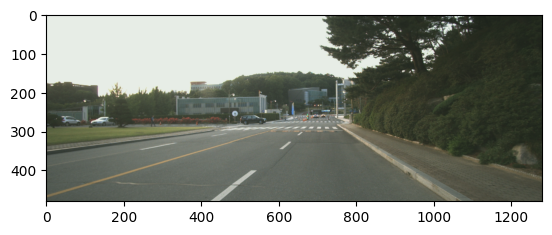

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
image_path = '/home/user/Dataset/ETRI_Dataset/val/Clockwise/img/000000.png'
image = Image.open(image_path)
image_array = np.array(image)
print(image_array.shape)
boxes = outputs[0]

fig, ax = plt.subplots()

# Display the image (placeholder, since no specific image was provided)
ax.imshow(image_array)

# Plot each bounding box
for box in boxes:
    print(box)
    # Convert from (cx, cy, w, h) to (x, y, w, h)
    x = box[0] - box[2] / 2
    y = box[1] - box[3] / 2
    
    # Create a rectangle patch
    rect = patches.Rectangle((x, y), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    
    # Add the rectangle to the Axes
    ax.add_patch(rect)

plt.show()

In [4]:
    
# Builder
logger = trt.Logger(trt.Logger.ERROR)
builder = trt.Builder(logger)
network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
profile = builder.create_optimization_profile()
config = builder.create_builder_config()
#config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 3 << 30)

# Onnx parser
parser = trt.OnnxParser(network, logger)

In [6]:
onnx_file_path ='./post_seg.onnx'
with open(onnx_file_path, 'rb') as model:
    parser.parse(model.read())

In [7]:
types = []
for i in range(len(network)):
    print('=====================', i)
    print(network[i].name)
    print(network[i].type)
    print(network[i].num_inputs)
    for ii in range(network[i].num_inputs):
        print(network[i].get_input(ii).name)
        print(network[i].get_input(ii).shape)
        print(network[i].get_input(ii).dtype)
    print(network[i].num_outputs)
    for ii in range(network[i].num_outputs):
        print(network[i].get_output(ii).name)
        print(network[i].get_output(ii).shape)
        print(network[i].get_output(ii).dtype)
        

===================== 0
(Unnamed Layer* 0) [Constant]
LayerType.CONSTANT
0
1
(Unnamed Layer* 0) [Constant]_output
(2,)
DataType.INT32
===================== 1
(Unnamed Layer* 1) [Shape]
LayerType.SHAPE
1
selected_segvec
(1, -1, 256)
DataType.FLOAT
1
(Unnamed Layer* 1) [Shape]_output
(3,)
DataType.INT32
===================== 2
(Unnamed Layer* 2) [Gather]
LayerType.GATHER
2
(Unnamed Layer* 1) [Shape]_output
(3,)
DataType.INT32
(Unnamed Layer* 0) [Constant]_output
(2,)
DataType.INT32
1
(Unnamed Layer* 2) [Gather]_output
(2,)
DataType.INT32
===================== 3
/Squeeze
LayerType.SHUFFLE
2
selected_segvec
(1, -1, 256)
DataType.FLOAT
(Unnamed Layer* 2) [Gather]_output
(2,)
DataType.INT32
1
/Squeeze_output_0
(-1, 256)
DataType.FLOAT
===================== 4
/Unsqueeze
LayerType.SHUFFLE
1
bg_vector
(256,)
DataType.FLOAT
1
/Unsqueeze_output_0
(1, 256)
DataType.FLOAT
===================== 5
/Concat
LayerType.CONCATENATION
2
/Squeeze_output_0
(-1, 256)
DataType.FLOAT
/Unsqueeze_output_0
(1, 256

In [ ]:

network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
tt = np.ones(shape=1, dtype=np.int32)*200
constant = network.add_constant(shape=(), weights=trt.Weights(tt))
max_output_boxes_per_class = constant.get_output(0)

tt = np.ones(shape=1, dtype=np.float32)*0.8
constant2 = network.add_constant(shape=(), weights=trt.Weights(tt))
iou_thresh = constant2.get_output(0)

tt = np.ones(shape=1, dtype=np.float32)*0.5
constant3 = network.add_constant(shape=(), weights=trt.Weights(tt))
score_thresh = constant3.get_output(0)
layer = network.add_nms(network.get_output(0), network.get_output(1),max_output_boxes_per_class )
layer.set_input(3,iou_thresh)
layer.set_input(4,score_thresh)

In [12]:

for ii in range(network[-1].num_inputs):
    print(network[-1].get_input(ii).name)

/Expand_output_0
/Slice_2_output_0


In [18]:

for ii in range(network.num_outputs):
    print(network.get_output(ii).name)

boxes
scores
mask_output
bg_vector
locations
actions


In [19]:
tt = np.ones(shape=1, dtype=np.int32)*200
constant = network.add_constant(shape=(), weights=trt.Weights(tt))
max_output_boxes_per_class = constant.get_output(0)

In [20]:
tt = np.ones(shape=1, dtype=np.float32)*0.8
constant2 = network.add_constant(shape=(), weights=trt.Weights(tt))
iou_thresh = constant2.get_output(0)

tt = np.ones(shape=1, dtype=np.float32)*0.5
constant3 = network.add_constant(shape=(), weights=trt.Weights(tt))
score_thresh = constant3.get_output(0)

In [21]:
layer = network.add_nms(network.get_output(0), network.get_output(1),max_output_boxes_per_class )


In [22]:
layer.set_input(3,iou_thresh)

In [23]:
layer.set_input(4,score_thresh)

In [24]:

layer.get_output(0).dtype = trt.int32
layer.get_output(1).dtype = trt.int32
network.mark_output(layer.get_output(0))
network.mark_output(layer.get_output(1))

In [55]:
for ii in range(network.num_outputs):
    print(network.get_output(ii).name)

boxes
scores
mask_output
bg_vector
locations
actions
Selected_indices
Num_selected


In [26]:

#network.unmark_output(network.get_output(0))
#network.unmark_output(network.get_output(1))

In [27]:
for ii in range(network.num_outputs):
    print(network.get_output(ii).shape)

(1, 12600, 4)
(1, 12600, 7)
(1, 256, 120, 320)
(256,)
(1, 12600, 9)
(1, 12600, 19)
(-1, 3)
()


In [53]:
network.get_output(7).name = 'Num_selected'
network.get_output(6).name = 'Selected_indices'


In [29]:
layer.bounding_box_format = trt.BoundingBoxFormat.CENTER_SIZES

In [30]:
layer.topk_box_limit = 200

In [54]:
types = []
for i in range(len(network)):
    print('=====================', i)
    print(network[i].name)
    print(network[i].type)
    print(network[i].num_inputs)
    for ii in range(network[i].num_inputs):
        print(network[i].get_input(ii).name)
        print(network[i].get_input(ii).shape)
        print(network[i].get_input(ii).dtype)
    print(network[i].num_outputs)
    for ii in range(network[i].num_outputs):
        print(network[i].get_output(ii).name)
        print(network[i].get_output(ii).shape)
        print(network[i].get_output(ii).dtype)
        

===================== 0
node_of_1264
LayerType.SLICE
1
images
(1, 3, 480, 1280)
DataType.FLOAT
1
1264
(1, 3, 240, 640)
DataType.FLOAT
===================== 1
node_of_1269
LayerType.SLICE
1
images
(1, 3, 480, 1280)
DataType.FLOAT
1
1269
(1, 3, 240, 640)
DataType.FLOAT
===================== 2
node_of_1274
LayerType.SLICE
1
images
(1, 3, 480, 1280)
DataType.FLOAT
1
1274
(1, 3, 240, 640)
DataType.FLOAT
===================== 3
node_of_1279
LayerType.SLICE
1
images
(1, 3, 480, 1280)
DataType.FLOAT
1
1279
(1, 3, 240, 640)
DataType.FLOAT
===================== 4
/backbone/backbone/stem/Concat
LayerType.CONCATENATION
4
1264
(1, 3, 240, 640)
DataType.FLOAT
1274
(1, 3, 240, 640)
DataType.FLOAT
1269
(1, 3, 240, 640)
DataType.FLOAT
1279
(1, 3, 240, 640)
DataType.FLOAT
1
/backbone/backbone/stem/Concat_output_0
(1, 12, 240, 640)
DataType.FLOAT
===================== 5
/backbone/backbone/stem/conv/conv/Conv
LayerType.CONVOLUTION
1
/backbone/backbone/stem/Concat_output_0
(1, 12, 240, 640)
DataType.FLOAT


In [32]:
print(network.get_output(4).shape)

(1, 12600, 9)


In [33]:
dynamic_axes = False
tensorrt_engine_path = 'trt.engine'
engine_precision = 'FP32'
dynamic_axes = False
img_size = [3,480,1280]
batch_size = 1
min_engine_batch_size = 1
opt_engine_batch_size = 1
max_engine_batch_size = 1
max_output_length = 200

In [34]:
inputTensor = network.get_input(0) 
# Dynamic batch (min, opt, max)
print('inputTensor.name:', inputTensor.name)

inputTensor.name: images


In [35]:
if dynamic_axes:
    profile.set_shape(inputTensor.name, (min_engine_batch_size, img_size[0], img_size[1], img_size[2]), \
        (opt_engine_batch_size, img_size[0], img_size[1], img_size[2]), \
        (max_engine_batch_size, img_size[0], img_size[1], img_size[2]))
    
    print('Set dynamic')
else:
    profile.set_shape(inputTensor.name, (batch_size, img_size[0], img_size[1], img_size[2]), \
        (batch_size, img_size[0], img_size[1], img_size[2]), \
        (batch_size, img_size[0], img_size[1], img_size[2]))
config.add_optimization_profile(profile)
#network.unmark_output(network.get_output(0))

# Write engine
engineString = builder.build_serialized_network(network, config)
if engineString == None:
    print("Failed building engine!")
    exit()
print("Succeeded building engine!")
with open(tensorrt_engine_path, "wb") as f:
    f.write(engineString)

Succeeded building engine!


In [36]:

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image
from PIL import Image
def get_transform(img_size):
    options = []
    #options.append(transforms.Resize((img_size[1], img_size[2])))
    options.append(transforms.ToTensor())
    #options.append(transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]))
    transform = transforms.Compose(options)
    return transform


def load_image_folder(folder_path, img_size, batch_size):
    transforming = get_transform(img_size)
    
    # List to hold processed images
    images_list = []
    
    # Iterate over all files in the directory
    for img_name in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        if os.path.isfile(img_path):
            # Load image
            with Image.open(img_path) as img:
                # Check if image is in 'RGB' mode (3 channels), if not convert it
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                # Apply transformations
                img_transformed = transforming(img)
                images_list.append(img_transformed)
                
                # Check if we have enough images for a batch
                if len(images_list) == batch_size:
                    # Convert list to a tensor
                    torch_images = torch.stack(images_list)
                    print('torch images size:', torch_images.size())
                    # Optionally save the first image in the batch
                    # Requires `save_image` from torchvision.utils
                    # save_image(torch_images[0], 'sample.png')
                    return torch_images.cpu().numpy()
    
    # Handle the case where the number of images is not a multiple of the batch_size
    if images_list:
        torch_images = torch.stack(images_list)
        print('torch images size:', torch_images.size())
        # Optionally save the first image in the batch
        # Requires `save_image` from torchvision.utils
        # save_image(torch_images[0], 'sample.png')
        return torch_images.cpu().numpy()
    else:
        return None

sample_folder_path = '/home/user/Dataset/ETRI_Dataset/val/Clockwise/img/'
img_resize = load_image_folder(sample_folder_path, img_size, batch_size).astype(np.float32)

torch images size: torch.Size([1, 3, 480, 1280])


In [37]:

TRT_LOGGER = trt.Logger()
with open(tensorrt_engine_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime: 
    engine = runtime.deserialize_cuda_engine(f.read())    
context = engine.create_execution_context()

In [38]:

context.set_binding_shape(0, (batch_size, img_size[0], img_size[1], img_size[2]))

/tmp/ipykernel_670623/1827723833.py:1: DeprecationWarning: Use set_input_shape instead.
  context.set_binding_shape(0, (batch_size, img_size[0], img_size[1], img_size[2]))


True

In [39]:

context.get_binding_shape(5)

/tmp/ipykernel_670623/4062174798.py:1: DeprecationWarning: Use get_tensor_shape instead.
  context.get_binding_shape(5)


(1, 12600, 9)

In [40]:
def trt_inference(engine, context, data):  
    
    nInput = np.sum([engine.binding_is_input(i) for i in range(engine.num_bindings)])
    nOutput = engine.num_bindings - nInput
    print('nInput:', nInput)
    print('nOutput:', nOutput)
    
    for i in range(nInput):
        print("Bind[%2d]:i[%2d]->" % (i, i), engine.get_binding_dtype(i), engine.get_binding_shape(i), context.get_binding_shape(i), engine.get_binding_name(i))
    for i in range(nInput,nInput+nOutput):
        print("Bind[%2d]:o[%2d]->" % (i, i - nInput), engine.get_binding_dtype(i), engine.get_binding_shape(i), context.get_binding_shape(i), engine.get_binding_name(i))
        
    bufferH = []
    bufferH.append(np.ascontiguousarray(data.reshape(-1)))
    
    for i in range(nInput, nInput + nOutput):
        if i<7:
            bufferH.append(np.empty(context.get_binding_shape(i), dtype=trt.nptype(engine.get_binding_dtype(i))))
        elif i==7:
            bufferH.append(np.empty((200,3), dtype=trt.nptype(engine.get_binding_dtype(i))))
        elif i==8:
            bufferH.append(np.empty(1, dtype=trt.nptype(engine.get_binding_dtype(i))))
            
    bufferD = []
    for i in range(nInput + nOutput):
        bufferD.append(cuda.cuMemAlloc(bufferH[i].nbytes)[1])

    for i in range(nInput):
        cuda.cuMemcpyHtoD(bufferD[i], bufferH[i].ctypes.data, bufferH[i].nbytes)
    
    context.execute_v2(bufferD)

    for i in range(nInput, nInput + nOutput):
        cuda.cuMemcpyDtoH(bufferH[i].ctypes.data, bufferD[i], bufferH[i].nbytes)
        
    for b in bufferD:
        cuda.cuMemFree(b)  
    
    return bufferH

In [41]:

trt_outputs = trt_inference(engine, context, img_resize)

nInput: 1
nOutput: 8
Bind[ 0]:i[ 0]-> DataType.FLOAT (1, 3, 480, 1280) (1, 3, 480, 1280) images
Bind[ 1]:o[ 0]-> DataType.FLOAT (1, 256, 120, 320) (1, 256, 120, 320) mask_output
Bind[ 2]:o[ 1]-> DataType.FLOAT (256,) (256,) bg_vector
Bind[ 3]:o[ 2]-> DataType.FLOAT (1, 12600, 4) (1, 12600, 4) boxes
Bind[ 4]:o[ 3]-> DataType.FLOAT (1, 12600, 7) (1, 12600, 7) scores
Bind[ 5]:o[ 4]-> DataType.FLOAT (1, 12600, 9) (1, 12600, 9) locations
Bind[ 6]:o[ 5]-> DataType.FLOAT (1, 12600, 19) (1, 12600, 19) actions
Bind[ 7]:o[ 6]-> DataType.INT32 (-1, 3) (0, 3) (Unnamed Layer* 579) [NMS]_output
Bind[ 8]:o[ 7]-> DataType.INT32 () () (Unnamed Layer* 579) [NMS]_output_1


/tmp/ipykernel_670623/2348315846.py:3: DeprecationWarning: Use get_tensor_mode instead.
  nInput = np.sum([engine.binding_is_input(i) for i in range(engine.num_bindings)])
/tmp/ipykernel_670623/2348315846.py:9: DeprecationWarning: Use get_tensor_dtype instead.
  print("Bind[%2d]:i[%2d]->" % (i, i), engine.get_binding_dtype(i), engine.get_binding_shape(i), context.get_binding_shape(i), engine.get_binding_name(i))
/tmp/ipykernel_670623/2348315846.py:9: DeprecationWarning: Use get_tensor_shape instead.
  print("Bind[%2d]:i[%2d]->" % (i, i), engine.get_binding_dtype(i), engine.get_binding_shape(i), context.get_binding_shape(i), engine.get_binding_name(i))
/tmp/ipykernel_670623/2348315846.py:9: DeprecationWarning: Use get_tensor_name instead.
  print("Bind[%2d]:i[%2d]->" % (i, i), engine.get_binding_dtype(i), engine.get_binding_shape(i), context.get_binding_shape(i), engine.get_binding_name(i))
/tmp/ipykernel_670623/2348315846.py:11: DeprecationWarning: Use get_tensor_dtype instead.
  print

In [42]:
for ii in trt_outputs:
    #if ii.shape[-1]==4:
    #    print(ii[:,::500,:])
    print(ii.shape, ii)


(1843200,) [0.90588236 0.90588236 0.90588236 ... 0.23529412 0.23921569 0.23921569]
(1, 256, 120, 320) [[[[0.09472616 0.09859229 0.09782667 ... 0.10615186 0.10526492
    0.09916578]
   [0.09271115 0.09521036 0.09423412 ... 0.10509156 0.10542303
    0.09882981]
   [0.09213245 0.09320828 0.09196157 ... 0.10641477 0.1064608
    0.09976494]
   ...
   [0.08886772 0.09221662 0.09104563 ... 0.09362634 0.09350804
    0.0947027 ]
   [0.08831102 0.09331985 0.09260092 ... 0.09575634 0.0947925
    0.09401409]
   [0.09192903 0.09627008 0.09378874 ... 0.10026518 0.0988841
    0.09829883]]

  [[0.23055024 0.2291048  0.22846255 ... 0.23554987 0.23893157
    0.24170396]
   [0.22591712 0.22407255 0.22422123 ... 0.2333976  0.237193
    0.23660003]
   [0.2280719  0.22492535 0.22413048 ... 0.23559424 0.2380204
    0.23773135]
   ...
   [0.23318052 0.23167717 0.23183453 ... 0.22737652 0.22814786
    0.23259874]
   [0.23032056 0.2333205  0.2340818  ... 0.23054844 0.22986652
    0.2321126 ]
   [0.2324901  0.23

0.96824384
0.9657363
0.95977676
0.92750657
0.92220384
0.90605783
0.88626146
0.85994244
0.58004785
[array([535.3137  , 270.7892  ,  68.535484,  27.596668], dtype=float32), array([147.41948 , 275.39252 ,  71.46113 ,  26.093367], dtype=float32), array([ 61.81861 , 274.23434 ,  60.974094,  27.465418], dtype=float32), array([696.8804  , 260.67706 ,  17.129543,  12.660174], dtype=float32), array([274.97418 , 273.36414 ,  19.2928  ,  29.379549], dtype=float32), array([716.65405 , 260.53882 ,  13.713766,  11.382321], dtype=float32), array([695.53436 , 233.51427 ,   9.560719,   4.338453], dtype=float32), array([706.04565  , 233.44914  ,   9.496177 ,   3.6678643], dtype=float32), array([705.86017  , 233.07658  ,   9.306789 ,   3.6303585], dtype=float32)]
[535.3137   270.7892    68.535484  27.596668]
[147.41948  275.39252   71.46113   26.093367]
[ 61.81861  274.23434   60.974094  27.465418]
[696.8804   260.67706   17.129543  12.660174]
[274.97418  273.36414   19.2928    29.379549]
[716.65405  260

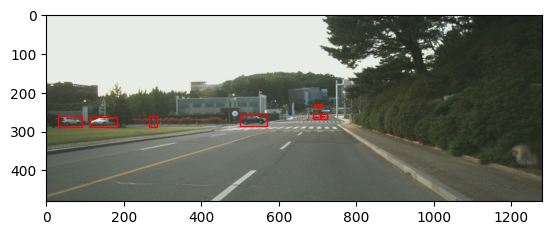

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image_array = img_resize[0]
image_array = np.array(image_array).transpose(1,2,0)
selected_idx = trt_outputs[-2]
num_det = trt_outputs[-1][0]
boxes = []
for i in range(num_det):
    boxes.append(trt_outputs[-6][0][selected_idx[i][2]])
    print(np.max(trt_outputs[-5][0][selected_idx[i][2]]))
print(boxes)

fig, ax = plt.subplots()

# Display the image (placeholder, since no specific image was provided)
ax.imshow(image_array)

# Plot each bounding box
for box in boxes:
    print(box)
    # Convert from (cx, cy, w, h) to (x, y, w, h)
    x = box[0] - box[2] / 2
    y = box[1] - box[3] / 2
    
    # Create a rectangle patch
    rect = patches.Rectangle((x, y), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    
    # Add the rectangle to the Axes
    ax.add_patch(rect)

plt.show()

In [45]:
print(trt_outputs[-4].shape)

NameError: name 'trt_outputs' is not defined

In [ ]:
boxes
scores
mask_output
bg_vector
locations
actions
Selected_indices
Num_selected

In [ ]:
from torch import nn

class PostProcessingNMS_trt(nn.Module):

    def forward(self, boxes, scores, mask_output, bg_vector, locations, actions, Selected_indices,Num_selected ):
        """
        Args:
            idx: selected indices from the boxes tensor. [num_selected_indices, 3],
                the selected index format is [batch_index, class_index, box_index]

            boxes: in (X, Y, H, W) format. Shape is: 
                [batch_size, spacial_dimensions, 4]

            scores: Shape is: [batch_size, spacial_dimensions, num_classes] 
        """        
        bbox_result = self.gather(boxes, idx)
        score_intermediate_result = self.gather(scores, idx).max(axis=-1)

        mask = score_intermediate_result.indices != 0

        bbox_result = bbox_result[mask]
        score_result = score_intermediate_result.values[mask]
        classes_result = score_intermediate_result.indices[mask]

        num_dets = torch.tensor(score_result.shape[-1]).clone().detach()
        return (bbox_result, score_result,  classes_result, num_dets)   

    def gather(self, target, idx):
        pick_indices = idx[:, -1:].repeat(1, target.shape[2]).unsqueeze(0)
        return torch.gather(target, 1, pick_indices)

In [63]:
aa = np.random.rand(1,30,4)*10//1
bb = np.random.rand(30,3)*10//1

In [69]:


def numpy_gather(target, idx):
    # Step 1: Prepare pick_indices
    # Get the last column of idx
    last_indices = idx[:, -1]
    # Repeat this column to match the third dimension of target
    # NumPy broadcasting will handle this during indexing, so explicit repeat is not needed
    # Unsqueeze (expand_dims) is to add a new axis, for compatibility with torch's unsqueeze
    last_indices = np.expand_dims(last_indices, axis=0).astype(int)
    
    # Step 2: Use advanced indexing to gather
    # Create a meshgrid for the batch dimension and the dimension to gather over (mimicking repeat)
    batch_indices = np.arange(target.shape[0])[:, None, None]
    gather_dim_indices = np.arange(target.shape[2])[None, :, None]
    
    # Adjust last_indices shape for broadcasting
    last_indices = last_indices[:, None, :]

    # Perform the gather operation
    # Note: The explicit repeat is not performed as in PyTorch. Instead, we rely on broadcasting.
    gathered = target[batch_indices, last_indices, gather_dim_indices]
    
    return gathered

# Example usage
# Assuming target and idx are defined as NumPy arrays with compatible shapes
# target shape: (batch_size, channels, height), idx shape: (batch_size, some_dimension)
target = np.random.rand(1, 10, 15)  # Example target array
idx = np.random.randint(0, 10, size=(5, 3))  # Example idx array


In [71]:
print(target, idx)
pp = numpy_gather(target,idx)

[[[0.28996209 0.74961923 0.51714163 0.79373574 0.88381212 0.32136008
   0.7554771  0.79104393 0.92011407 0.72018632 0.93696475 0.97176363
   0.33107775 0.29808625 0.40551597]
  [0.44547683 0.56148695 0.67247018 0.8333844  0.39325746 0.4086662
   0.91295459 0.18113622 0.98510782 0.74884238 0.30904602 0.98723692
   0.15695952 0.09682742 0.42748168]
  [0.57731682 0.51591304 0.92614851 0.13941772 0.95549135 0.90080504
   0.47427156 0.07502446 0.4934997  0.44418281 0.23331763 0.45245847
   0.86294457 0.28258782 0.91839014]
  [0.95180076 0.74825241 0.92499013 0.3505912  0.20997044 0.41005464
   0.78974544 0.87880284 0.16213802 0.87655815 0.51160067 0.9161095
   0.90291742 0.57462175 0.43076274]
  [0.96222498 0.27399461 0.8135758  0.86643081 0.55403285 0.79091113
   0.31077447 0.20199571 0.52653956 0.43635612 0.63920909 0.38366182
   0.11484339 0.36564535 0.4376508 ]
  [0.77442378 0.17983552 0.76720783 0.83446607 0.53100509 0.44842518
   0.97765598 0.7952281  0.51459496 0.41810703 0.86012774 

In [78]:
print(pp.max(2).shape)
print(pp.shape)

(1, 15)
(1, 15, 5)


In [ ]:
class Yolov8(nn.Module):
    def __init__(self, jit_path):
        super().__init__()
        self.net = torch.jit.load(jit_path)
        self.conf_thresh = 0.3
        self.nms_thresh  = 0.7
        self.do_nms      = True
    
    def forward(self, x):
        dets        = self.net(x).transpose(1,2)
        idxs        = torch.where(dets[...,4] > self.conf_thresh)
        dets        = dets[idxs]
        x,y,w,h     = dets[...,:4].chunk(4, -1)
        dets[:,:4]  = torch.cat([x-w/2,y-h/2,x+w/2,y+h/2],-1)

        if not self.do_nms:
            return idxs[0], dets
    
        return self.nms(idxs[0], dets, self.nms_thresh)
        
    @torch.no_grad()
    def nms(self, indices, dets, nms_thresh):
        nms     = torchvision.ops.batched_nms(dets[:,:4], dets[:,4], indices, nms_thresh)
        indices = indices[nms]
        dets    = dets[nms]
        return indices, dets 